# Homework 7
### Benjamin Tollison
I am a firm beliver that your code should be readible on it's own without comments,avoid single letter variables because LSP's exist, and you should never go beyond 2 nests to maintain readablity. Since the assignment has asked for comments to explain what is happening, I will use markdown and include my derivation of equations in the markdown. Here is a ~6min video explaining how to get rid of comments in your code:\
https://www.youtube.com/watch?v=Bf7vDBBOBUA

This first block of code is just a header that I use for all of my assignments because print statements should only be used for troubleshooting.(and for outputting latex to easily put into assignments)

In [177]:
### Benjamin Tollison ###
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sympy as sp
from IPython.display import Latex, Math, display
from sympy import (
    Eq,
    Function,
    Matrix,
    cos,
    cosh,
    exp,
    integrate,
    lambdify,
    pi,
    sin,
    sinh,
    symbols,
)
from decimal import Decimal
from sympy.solvers.pde import pdsolve
from sympy.solvers.solveset import linsolve
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)
def displayVariable(variable:str,RHS):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
def displayVariableWithUnits(variable:str,RHS,units):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    latexUnit = sp.latex(symbols(units))
    display(Math(left + '=' + right + '\\;' +'\\left['+ latexUnit + '\\right]'))
def format_scientific(number:float):
    a = '%E' % number
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]
deg2rad = np.pi/180
rad2deg = 180/np.pi

### Question 1
As a note for notation wise:\
I use Area defined as $\sigma$ to stay consistent with 351 Cizmas.\
Setting the given equation to the definition of the critical area ratio in the book
$$\frac{\sigma}{\sigma_{cr}} = 
\frac{8-4\cos(\pi x)}{4} = 
\frac{1}{M} \left[\frac{2}{\gamma+1}\left(1+\frac{\gamma-1}{2}M^2\right)\right]^\frac{\gamma+1}{2(\gamma-1)}$$
Knowing that $\gamma = 1.4$ and that $-0.25<x<1$ we can us Householder's second order root method from the nasa report:\
https://www.grc.nasa.gov/www/winddocs/utilities/b4wind_guide/mach.html
$$ x_{i+1} = x_i - \frac{2f}{f'-\sqrt{f'^2-ff''}}$$
With the subsonic regime being defined by:
$$f = (P+QX)^\frac{1}{Q} - RX = 0$$
$$f' = (P+QX)^{\frac{1}{Q}-1} - R$$
$$f'' = P(P+QX)^{\frac{1}{Q}-2}$$
and the supersonic regime can be found with the following:
$$f = (PX+Q)^\frac{1}{P} - RX = 0$$
$$f' = (PX+Q)^{\frac{1}{P}-1} - R$$
$$f'' = Q(PX+Q)^{\frac{1}{P}-2}$$
And the Coefficients can be defined by:
$$P=\frac{2}{\gamma+1}$$
$$Q = \frac{\gamma-1}{\gamma+1}=1-P $$
$$X_{subsonic} = M^2$$
$$X_{supersonic} = \frac{1}{M^2}$$
$$R_{subsonic} = \left(\frac{\sigma}{\sigma_{cr}}\right)^2$$
$$R_{supersonic} = \left(\frac{\sigma}{\sigma_{cr}}\right)^\frac{2Q}{P}$$
Therefore we can have 4 possible solutions. Subsonic->subsonic, subsonic->supersonic, supersonic->subsonic, or supersonic->supersonic

In [178]:
def HouseholdP2(x_intial:float,scheme_function,scheme_prime,scheme_double_prime)->float:
  max_iterations = 1000
  while abs(scheme_function(x_intial)) > 1e-8:
    x_intial = x_intial - ((2*scheme_function(x_intial))/(scheme_prime(x_intial) - (scheme_prime(x_intial)**2-scheme_function(x_intial)*scheme_double_prime(x_intial))**0.5))
    max_iterations -=1
    if max_iterations ==0:
      print('The scheme didn\'t converge')
      break
  return x_intial
def Householder(x_position:float,section_supersonic:bool,area_function)->float:
  P = 2/2.4
  Q = 1-P
  if section_supersonic==False:
    R = (area_function(x_position))**2
    a = P**(1/Q)
    r = (R-1)/(2*a)
    x_intial = 1 / ((1+r)+np.sqrt(r*(r+2)))
    f = lambda X : (P+Q*X)**(1/Q) - R*X
    f_prime = lambda X: (P+Q*X)**((1/Q)-1) - R
    f_double_prime = lambda X: P*(P+Q*X)**((1/Q)-2)
    x_final = HouseholdP2(x_intial,f,f_prime,f_double_prime)
    return (x_final)**0.5
  if section_supersonic == True:
    R = (area_function(x_position))**(2*Q/P)
    a = Q**(1/P)
    r = (R-1)/(2*a)
    x_intial = 1 / ((1+r)+np.sqrt(r*(r+2)))
    f = lambda X : (P*X+Q)**(1/P) - R*X
    f_prime = lambda X: (P*X+Q)**((1/P)-1) - R
    f_double_prime = lambda X: Q*(P*X+Q)**((1/P)-2)
    x_final = abs(HouseholdP2(x_intial,f,f_prime,f_double_prime))
    return 1/(x_final)**0.5
original_geometry = lambda x:2-np.cos(np.pi*x)
mach_values = {'SubsonicOnly':[],'Subsonic/Supersonic':[],'Supersonic/Subsonic':[],'SupersonicOnly':[]}
area_ratio = {'Area/Area_cr':[]}
x_values_section_1 = np.linspace(-0.25,0,200)
x_values_section_2 = np.linspace(0,1,800)
area_ratio['Area/Area_cr'] = [original_geometry(x) for x in x_values_section_1] + [2-np.cos(np.pi*x) for x in x_values_section_2]
mach_values['SubsonicOnly'] = [Householder(x,False,original_geometry)for x in x_values_section_1] + [Householder(x,False,original_geometry)for x in x_values_section_2]
mach_values['Subsonic/Supersonic'] = [Householder(x,False,original_geometry)for x in x_values_section_1] + [Householder(x,True,original_geometry)for x in x_values_section_2]
mach_values['Supersonic/Subsonic'] = [Householder(x,True,original_geometry)for x in x_values_section_1] + [Householder(x,False,original_geometry)for x in x_values_section_2]
mach_values['SupersonicOnly'] = [Householder(x,True,original_geometry)for x in x_values_section_1] + [Householder(x,True,original_geometry)for x in x_values_section_2]

The other 2 functions are for grading purposes and can be executed in the same way the PlotAllSolutions is by uncommenting

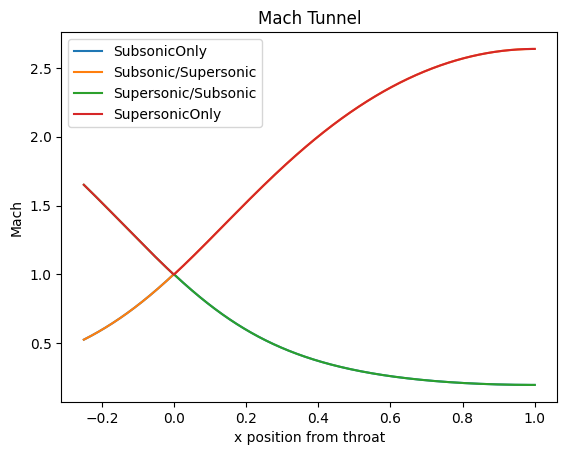

In [179]:
def CheckValues(dictionary:dict,dictionary_name:str):
  pd.DataFrame.from_dict(dictionary).to_csv(f'{dictionary_name}.csv')
  display(pd.DataFrame.from_dict(dictionary))
  return None
def Plot4DifferentSolutions(dictionary:dict,dictionary_name:str):
  situations = list(dictionary.keys())
  for i in situations:
    plt.plot(np.linspace(-0.25,1,1000),dictionary[i],label=i)
    plt.title(i)
    plt.xlabel('x position from throat')
    plt.ylabel(dictionary_name)
    plt.show()
  return None
def PlotAllSolutions(dictionary:dict,dictionary_name:str):
  situations = list(dictionary.keys())
  for i in situations:
    plt.plot(np.linspace(-0.25,1,1000),dictionary[i],label=i)
    plt.title('Mach Tunnel')
    plt.xlabel('x position from throat')
    plt.ylabel(dictionary_name)
    plt.legend()
  plt.savefig(f'{dictionary_name}.png')
  plt.show()
PlotAllSolutions(mach_values,'Mach')
# Plot4DifferentSolutions(mach_values,'Mach')
# CheckValues(mach_values,'Mach')

### Question 2
To find the stagnation pressure ratio as a function of mach, I used the following equation:
$$\frac{P_0}{P} = \left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{\gamma-1}$$
$$\Rightarrow \frac{P}{P_0} = \left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{1-\gamma}$$
The extra 2 functions are for grading purposes and just uncomment them to run

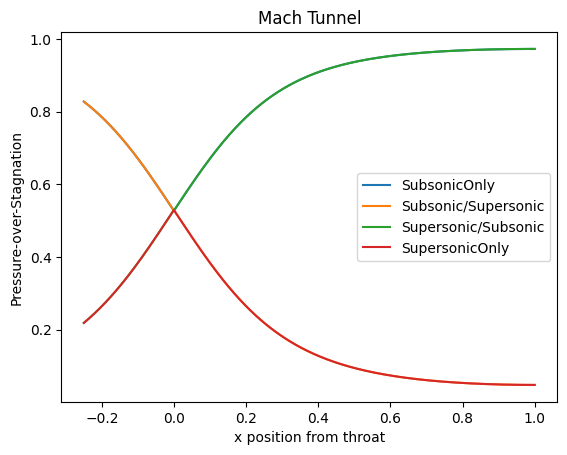

In [180]:
pressure_over_stagnation_function = lambda Mach_number: (1+.2*Mach_number**2)**(1.4/-0.4)
pressure_over_stagnation = {
  'SubsonicOnly':[pressure_over_stagnation_function(m) for m in mach_values['SubsonicOnly']],
  'Subsonic/Supersonic':[pressure_over_stagnation_function(m) for m in mach_values['Subsonic/Supersonic']],
  'Supersonic/Subsonic':[pressure_over_stagnation_function(m) for m in mach_values['Supersonic/Subsonic']],
  'SupersonicOnly':[pressure_over_stagnation_function(m) for m in mach_values['SupersonicOnly']]
}
PlotAllSolutions(pressure_over_stagnation,'Pressure-over-Stagnation')
# Plot4DifferentSolutions(pressure_over_stagnation,'Pressure-over-Stagnation')
# CheckValues(pressure_over_stagnation,'Pressure-over-Stagnation')

### Questions 3 through 12
No computation, just outputing values for the questions since all the values are stored in the dictionarys

In [181]:
displayVariable('3)M_{x=1}',mach_values['SubsonicOnly'][-1])
displayVariable('4)\\frac{P}{P_0}|_{x=1}',pressure_over_stagnation['SubsonicOnly'][-1])
displayVariable('5)M_{x=1}',mach_values['SupersonicOnly'][-1])
displayVariable('6)\\frac{P}{P_0}|_{x=1}',pressure_over_stagnation['SupersonicOnly'][-1])
displayVariable('7)M_{x=0}',mach_values['SupersonicOnly'][200])
displayVariable('8)\\frac{\\sigma}{\\sigma_{cr}}',area_ratio['Area/Area_cr'][200])
displayVariable('9)M_{x=-0.25}',mach_values['SubsonicOnly'][0])
displayVariable('10)\\frac{P}{P_0}|_{x=-0.25}',pressure_over_stagnation['SubsonicOnly'][0])
displayVariable('11)M_{x=-0.25}',mach_values['SupersonicOnly'][0])
displayVariable('12)\\frac{P}{P_0}|_{x=-0.25}',pressure_over_stagnation['SupersonicOnly'][0])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Question 13
Starting from the isentropic pressure ratio equation we can solve for mach:
$$\frac{P}{P_0} = \left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{1-\gamma}$$
$$\left(\frac{P}{P_0}\right)^\frac{1-\gamma}{\gamma}-1= \frac{\gamma-1}{2}M^2$$
$$\frac{2\left(\frac{P}{P_0}\right)^\frac{1-\gamma}{\gamma}-2}{\gamma-1} = M^2$$
$$\therefore M = \sqrt{\frac{2\left(\frac{P}{P_0}\right)^\frac{1-\gamma}{\gamma}-2}{\gamma-1}}$$

In [182]:
MachFromPressureRatio = lambda pressure_ratio: np.sqrt((2*pressure_ratio**(-.4/1.4)-2)/.4)
displayVariable('M_{exit}',MachFromPressureRatio(0.99))

<IPython.core.display.Math object>

### Question 14
To find the area ratio of the exit we have to plug in the value obtained from question 13 to:
$$\frac{\sigma_{exit}}{\sigma_{cr}} = 
\frac{1}{M_{exit}} \left[\frac{2}{\gamma+1}\left(1+\frac{\gamma-1}{2}M_{exit}^2\right)\right]^\frac{\gamma+1}{2(\gamma-1)}$$

In [183]:
AreaRatioFromMach = lambda M: (1/M) * ((2/2.4)*(1+(.2)*M**2))**(2.4/(.8))
area_ratio_at_exit = AreaRatioFromMach(MachFromPressureRatio(0.99))
displayVariable('\\frac{\\sigma_{exit}}{\\sigma^*}',area_ratio_at_exit)

<IPython.core.display.Math object>

### Question 15
Setting our original equation to the new exit ratio when x=1 we can solve for the new constant.
$$\frac{\sigma_{exit}}{\sigma^*} = C - \cos(\pi)$$
$$\rightarrow C = 3.86793095561905 $$

In [184]:
NewAreaRatio = lambda x: (area_ratio_at_exit-1) - np.cos(np.pi*x)
displayVariable('\\frac{\\sigma_{throat}}{\\sigma^*}',NewAreaRatio(0))

<IPython.core.display.Math object>

### Question 16
To find the Mach at this new area ratio we can take the same iterative method but change the R value to the new area ratio function. Also, since the nozzle at the exit is subsonic and the area ratio never hits 1, then the flow is subsonic throughout the entire test section.

In [185]:
new_geometry = lambda x: (area_ratio_at_exit-1) - np.cos(np.pi*x)
M_throat = Householder(0,False,new_geometry)
displayVariable('M_{throat}',M_throat)

<IPython.core.display.Math object>

### Question 17
Then we can plot this new numerical scheme across the range of x values

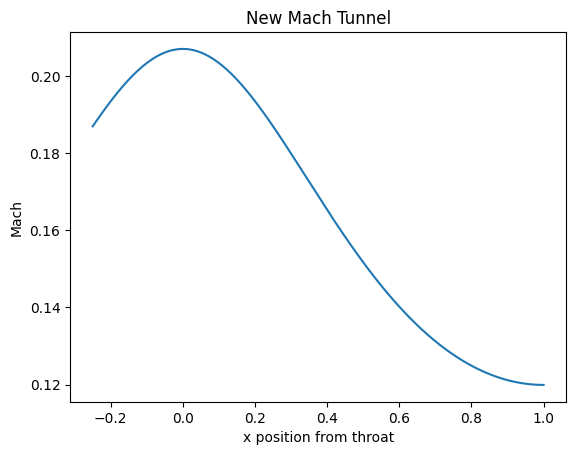

In [186]:
x_values_new_tunnel = np.linspace(-0.25,1,1000)
new_mach_values = [Householder(x,False,new_geometry) for x in x_values_new_tunnel]
plt.plot(x_values_new_tunnel,new_mach_values)
plt.title('New Mach Tunnel')
plt.xlabel('x position from throat')
plt.ylabel('Mach')
plt.savefig('New-Mach-Tunnel.png')
plt.show()

### Question 18
Using the same stagnation pressure ratio, we can plot the new pressure ratios
$$\frac{P}{P_0} = \left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{1-\gamma}$$

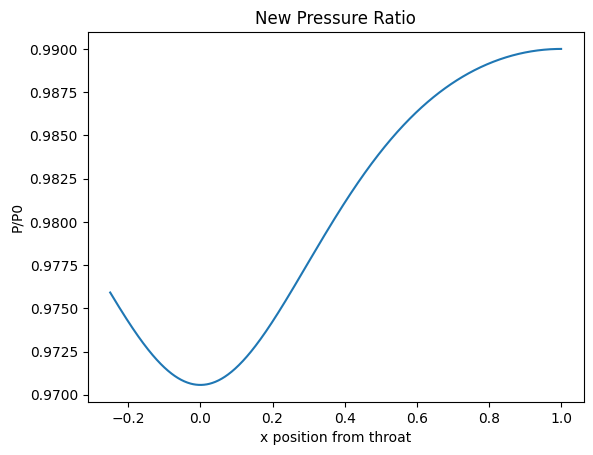

In [187]:
new_pressure_over_stagnation = [pressure_over_stagnation_function(M) for M in new_mach_values]
plt.plot(x_values_new_tunnel,new_pressure_over_stagnation)
plt.title('New Pressure Ratio')
plt.xlabel('x position from throat')
plt.ylabel('P/P0')
plt.savefig('New-Pressure-Ratio.png')
plt.show()

### Question 19
Since my mesh size is 1000, we can find the index of where x=0.5 with a linear interpolation:
$$index = \frac{0.5+0.25}{1+0.25}(1000-0)$$
$$index = 600$$
Converting to Python indexing system the index is 599

In [188]:
pressure_over_stagnation_at_x_half = new_pressure_over_stagnation[599]
displayVariable('\\frac{P}{P_0}|_{x=0.5}',pressure_over_stagnation_at_x_half)

<IPython.core.display.Math object>

### Question 20
The upstream shock is going to be the same as the isentropic flow situtation because the information of the shock cannot travel infront of the shock. However, to form the shock the upstream flow must start supersonic and I am using the same geometry for the tunnel from the last problem. (The plotting function is just to double check that the numerical solver is working)

In [189]:
def DisplayNewSupersonicOnlyTunnel():
  plt.plot(x_values_new_tunnel,[Householder(x,True,new_geometry) for x in x_values_new_tunnel])
  plt.title('Supersonic Only new Mach Tunnel')
  plt.ylabel('Mach')
  plt.xlabel('x position from throat')
  plt.show()
  return None
# DisplayNewSupersonicOnlyTunnel()
M1 = Householder(0.5,True,new_geometry)
displayVariable('M_{1\\,x=0.5}',M1)

<IPython.core.display.Math object>

### Question 21
Starting with the Prandlt Relation for adabatic flow for normal shocks:
$$u_1u_2 = a_{cr}^2$$
$$\left(\frac{\gamma-1}{2}+\frac{1}{M_1^2}\right)\left(\frac{\gamma-1}{2}+\frac{1}{M_2^2}\right) = \left(\frac{\gamma+1}{2}\right)^2$$
which can be re-arranged to find $M_2$
$$M_2 = \sqrt{\frac{M_1^2 + \frac{2}{\gamma-1}}{\frac{2\gamma}{\gamma-1}M_1^2-1}}$$

In [190]:
M2 = np.sqrt((M1**2+(2/.4))/((2.8/.4)*M1**2-1))
displayVariable('M_2',M2)

<IPython.core.display.Math object>

### Question 22
Starting from ratio of pressures over a shock:
$$\frac{P_2}{P_1} = \frac{M_1}{M_2} \sqrt{\frac{T_2}{T_1}}$$
$$\frac{P_2}{P_1} = \frac{1+\gamma M_1}{1+\gamma M_2}$$
Then plugging in the equation from the last question simplifies to:
$$\frac{P_2}{P_1} = \frac{2\gamma}{\gamma+1}M_1^2 - \frac{\gamma-1}{\gamma+1}$$

In [191]:
pressure_ratio = (2.8/2.4)*M1**2 - (.4/2.4)
displayVariable('\\frac{P_2}{P_1}',pressure_ratio)

<IPython.core.display.Math object>

### Question 23
Then using the stagnation ratio:
$$\frac{P_0}{P} = \left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{\gamma-1}$$
$$\left(\frac{P_{01}}{P_1}\right)^{-1}\left(\frac{P_{02}}{P_2}\right) = \frac{\left[\frac{\frac{\gamma+1}{2}M_1^2}{1+\frac{\gamma-1}{2}M_1^2}\right]^\frac{\gamma}{\gamma-1}}{\left(\frac{2\gamma}{\gamma+1}M_1^2 - \frac{\gamma-1}{\gamma+1}\right)^\frac{1}{\gamma-1}}$$

In [192]:
stagnation_pressure_ratio = (((2.4/2)*M1**2)/(1+(.4/2)*M1**2))**(1.4/.4) / ((2.8/2.4)*M1**2 - (.4/2.4))**(1/.4)
displayVariable('\\frac{P_{02}}{P_{01}}',stagnation_pressure_ratio)

<IPython.core.display.Math object>

### Question 24
Making the assumption that the notation of the * does not mean critical or throat, and that it just means a new state.
$$\frac{\sigma^*_2}{\sigma_{throat}} = 
\frac{1}{M} \left[\frac{2}{\gamma+1}\left(1+\frac{\gamma-1}{2}M^2\right)\right]^\frac{\gamma+1}{2(\gamma-1)}$$

In [193]:
area_ratio_star_2 = AreaRatioFromMach(M2)
displayVariable('\\frac{\\sigma^*_2}{\\sigma_{throat}}',area_ratio_star_2)

<IPython.core.display.Math object>

### Question 25
Setting the inverse of the last problem as $\frac{\sigma_{throat}}{\sigma^*_2} $ and we know that $\frac{\sigma(x)}{\sigma_{throat}} =2-\cos(\pi x)$ from the original geometry.
$$\frac{\sigma(x)}{\sigma^*_2} = \frac{\sigma_{throat}}{\sigma^*_2}[2-\cos(\pi x)]$$
Then, using this new function in the Householder's method, we can find the $M_{exit}$ by assuming that exit velocity is also subsonic by using figure 10.15

In [194]:
part3geometry = lambda x: (area_ratio_star_2**-1)*(2 - np.cos(np.pi*x))
M_exit = Householder(1,False,part3geometry)
displayVariable('M_{exit}',M_exit)

<IPython.core.display.Math object>

### Question 26
$$\frac{P_{exit}}{P_0} = \frac{P_{exit}}{P_{02}} \frac{P_{02}}{P_{01}}$$

In [195]:
stagnation_pressure_post_shock = (1+.2*M_exit**2)**(1.4/-.4)
pressure_exit_ratio = stagnation_pressure_ratio*stagnation_pressure_post_shock
displayVariable('\\frac{P_{exit}}{P_0}',pressure_exit_ratio)

<IPython.core.display.Math object>

### Question 27
Now to create an iterative scheme to check when $\frac{P_{exit}}{P_0} = 0.5$ by testing when the original geometry at supersonic flow develops a shock to get the appropriate ratio: \
-First, is to use the original geometry at supersonic flow to iterate for $M_1$ at a given x position\
-then to find the $M_2$ as a function of the changing $M_1$\
-create the new area ratio to produce a new area function\
-find the exit pressure ratio\
-Check if it is really close to 0.5

In [229]:
original_geometry = lambda x:2-np.cos(np.pi*x)
for x_position in np.linspace(-0.25,1,1000):
  M1 = Householder(x_position,True,original_geometry)
  M2 = np.sqrt((M1**2+(2/.4))/((2.8/.4)*M1**2-1))
  area_ratio_star_2 = AreaRatioFromMach(M2)
  new_area_function = lambda x: (area_ratio_star_2**-1)*(2-np.cos(np.pi*x))
  M_exit = Householder(1,False,new_area_function)
  stagnation_pressure_ratio = (((2.4/2)*M1**2)/(1+(.4/2)*M1**2))**(1.4/.4) / ((2.8/2.4)*M1**2 - (.4/2.4))**(1/.4)
  stagnation_pressure_post_shock = (1+.2*M_exit**2)**(1.4/-.4)
  pressure_exit_ratio = stagnation_pressure_ratio*stagnation_pressure_post_shock
  if abs(pressure_exit_ratio - 0.5) < 1e-4:
    x_location_of_shock = x_position
    print(new_area_function(.6))
displayVariable('x_{shock}',x_location_of_shock)

1.7696573741199364


<IPython.core.display.Math object>

### Question 28
To plot the Mach graph we can use the exit pressure and walk the subsonic mach function back to the shock location, and then we can walk the supersonic solution to the throat, then supersonic to the shock location.

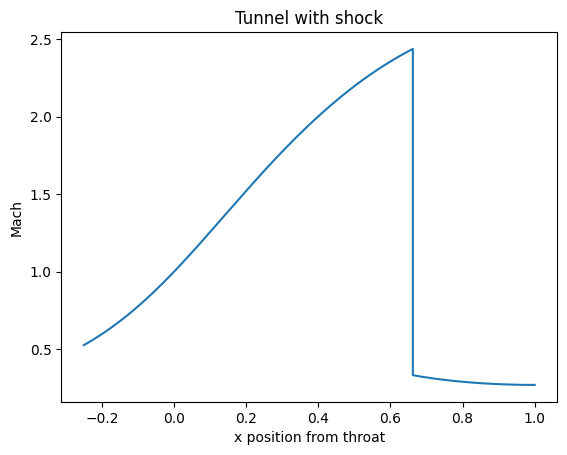

In [230]:
x_values_section_1 = np.linspace(-0.25,0,200)
x_values_section_2 = np.linspace(0,x_location_of_shock,500)
x_values_section_3 = np.linspace(x_location_of_shock,1,300)
mach_values_shock = [Householder(x,False,original_geometry)for x in x_values_section_1]+[Householder(x,True,original_geometry)for x in x_values_section_2]+[Householder(x,False,new_area_function) for x in x_values_section_3]
x_values_both = [x for x in x_values_section_1] + [x for x in x_values_section_2] + [x for x in x_values_section_3]
plt.plot(x_values_both,mach_values_shock)
plt.title('Tunnel with shock')
plt.ylabel('Mach')
plt.xlabel('x position from throat')
plt.savefig('Mach-with-shock.png')
plt.show()

### Question 29
Plotting this new set of mach values into the pressure ratio with produce
$$\frac{P}{P_0} = \left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{1-\gamma}$$

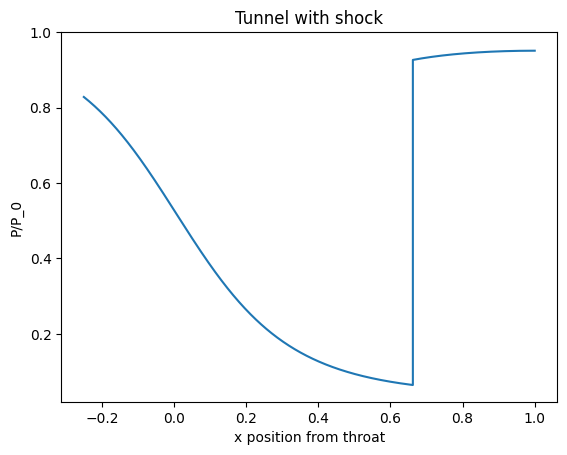

In [231]:
pressure_over_stagnation_shock = [pressure_over_stagnation_function(m)for m in mach_values_shock]
plt.plot(x_values_both,pressure_over_stagnation_shock)
plt.title('Tunnel with shock')
plt.ylabel('P/P_0')
plt.xlabel('x position from throat')
plt.ylim(top=1)
plt.savefig('Pressure-with-shock.png')
plt.show()